In [72]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import glob
from datetime import datetime
from statsmodels.tsa.statespace import sarimax
from sklearn.preprocessing import StandardScaler
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing,Holt

In [3]:
start_time = datetime.now()
all_csv = glob.glob(f'../data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/**/*.csv', recursive=True)
end_time = datetime.now()
print(f'Loaded the paths of {len(all_csv)} files from disk. Took {end_time-start_time}')

Loaded the paths of 100 files from disk. Took 0:00:00.520142


In [61]:
df = pd.read_csv(all_csv[0])
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds
df_indexed = df.set_index('timestamp')

In [62]:
# prepare data for standardization
values = df_indexed.copy()
values = values.drop(columns=['is_anomaly'],axis=1)
#values = values.reshape((len(values), 1))
# train the standardization
scaler2 = StandardScaler()
scaler2 = scaler2.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler2.mean_, sqrt(scaler2.var_)))
# standardize the dataset
standardaized = scaler2.transform(values)

df['std_value'] = standardaized
df_indexed['std_value'] = standardaized

# prepare data for normalization
# values = df_indexed.copy()
# values = values.drop(columns=['value','is_anomaly'],axis=1)
values = np.array(df['std_value'])
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)

df['norm_value'] = normalized
df_indexed['norm_value'] = normalized


Mean: 4471.669226, StandardDeviation: 2925.391670
Min: -1.809898, Max: 5.219308


In [63]:
df.index.freq = 'MS'
# split dataset
X = df.norm_value
size = int(len(X)*0.5)
train, test = X[0:size], X[0:len(X)]

In [70]:
#model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7).fit()
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)
pred = hw_model.predict(start=test.index[0], end=test.index[-1])

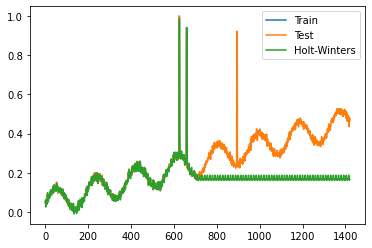

In [69]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

/home/sanketm/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


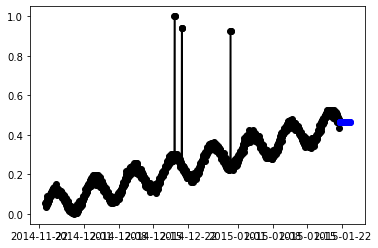

In [88]:
fit3 = SimpleExpSmoothing(df_indexed.copy().drop(columns=['is_anomaly','std_value','value'],axis=1)).fit()
fcast3 = fit3.forecast(50).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
plt.plot(df_indexed['norm_value'], marker='o', color='black')
plt.plot(fcast3, marker='o', color='blue')

In [39]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))


    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)
    
    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))

In [40]:
model_eval(X,pred)

Mean Absolute Error: 0.112
Mean Squared Error: 1.0
Root Mean Squared Error: 0.338
Mean absolute percentage error: 51.873
Scaled Mean absolute percentage error: 39.191
Mean forecast error: 0.996
Normalised mean squared error: 0.114
Theil_u_statistic: 0.339


In [47]:
# Normalize time series data
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
# load the dataset and print the first 5 rows
series = df['std_value'] #read_csv('daily-minimum-temperatures-in-me.csv', header=0, index_col=0)
print(series.head())
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
	print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
	print(inversed[i])

0   -1.426763
1   -1.534292
2   -1.385583
3   -1.372206
4   -1.422086
Name: std_value, dtype: float64
Min: -1.809898, Max: 5.219308
[0.05450614]
[0.0392087]
[0.06036451]
[0.06226755]
[0.0551715]
[-1.42676284]
[-1.5342917]
[-1.38558317]
[-1.37220635]
[-1.42208594]


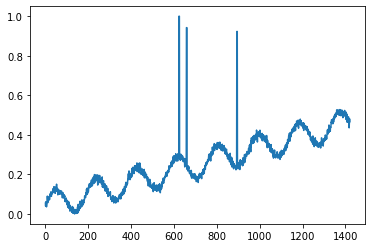

In [48]:
plt.plot(normalized)